CODE BLOCK: 1

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [11]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? False


CODE BLOCK: 3

In [12]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [13]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [14]:
batch_size = 32  #batch_size of 512 for MNIST is an overkill

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True} #shuffle needs to be true, num_workers==2 is under-implementing the parallelism provided by T4 GPU, it should be around 8.

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

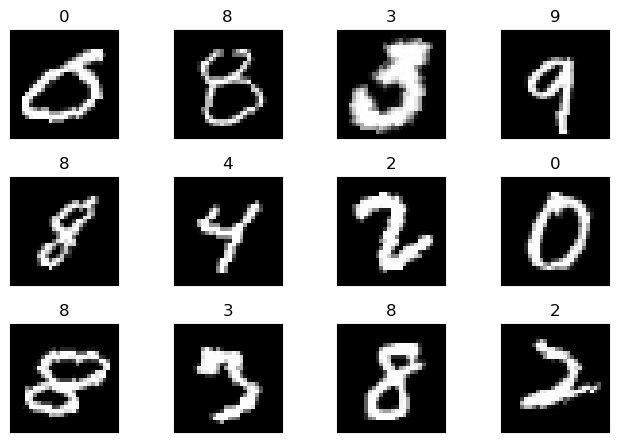

In [15]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

num_frames = 12
for i in range(num_frames):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [16]:
len(next(iter(train_loader))[0])

32

CODE BLOCK: 7

In [17]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, bias = False) #in = 28x28x1, out = 26x26x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, bias = False) #in = n x n x 32, out = n-2 x n-2 x 64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, bias = False) #in = n x n x 64, out = n-2 x n-2 x 128
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, bias = False) #in = n x n x 128, out = n-2 x n-2 x 256
        self.fc1 = nn.Linear(4096, 512, bias = False) # should be nn.Linear(4096,50) TODO: Try with a bigger output layer size
        self.fc2 = nn.Linear(512, 10, bias = False)  # TODO: try with a bigger input layer corresponding fc2.

    def forward(self, x):
        # 28x28x1 
        x = self.conv1(x)  #relu is being applied to height and width only, the second parameter (2 here) should be 32 to cover all the channels. TODO: test without ReLU.
        # 26x26x32
        x = F.max_pool2d(self.conv2(x), 2)
        # 12x12x64
        x = self.conv3(x)
        # 10x10x128
        x = F.max_pool2d(self.conv4(x), 2)
        # 4x4x256
        x = x.view(-1, 4096) #The value here should be (-1, 4096) TODO: Run with default parameters
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [18]:
# !pip install torchsummary
from torchsummary import summary
use_mps = torch.backends.mps.is_available()
print(use_mps)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if use_mps else "cpu")
print(f'device: {device}')
model = Net().to(device)
# summary(model, input_size=(1, 28, 28))

True
device: mps


CODE BLOCK: 8

In [20]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 8

In [ ]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 9

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.1625 Batch_id=1874 Accuracy=94.46: 100%|██████████| 1875/1875 [00:49<00:00, 38.19it/s]


Test set: Average loss: 0.0495, Accuracy: 9842/10000 (98.42%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0343 Batch_id=1874 Accuracy=97.79: 100%|██████████| 1875/1875 [00:45<00:00, 41.05it/s]


Test set: Average loss: 0.0315, Accuracy: 9899/10000 (98.99%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=1.0541 Batch_id=1874 Accuracy=98.25: 100%|██████████| 1875/1875 [00:45<00:00, 41.35it/s]


Test set: Average loss: 0.0369, Accuracy: 9899/10000 (98.99%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0031 Batch_id=1874 Accuracy=98.62: 100%|██████████| 1875/1875 [00:43<00:00, 43.15it/s]


Test set: Average loss: 0.0388, Accuracy: 9880/10000 (98.80%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0681 Batch_id=1874 Accuracy=98.74: 100%|██████████| 1875/1875 [00:43<00:00, 42.63it/s]


Test set: Average loss: 0.0318, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0002 Batch_id=1874 Accuracy=98.73: 100%|██████████| 1875/1875 [00:44<00:00, 42.17it/s]


Test set: Average loss: 0.0331, Accuracy: 9900/10000 (99.00%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0052 Batch_id=1874 Accuracy=98.89: 100%|██████████| 1875/1875 [00:44<00:00, 42.00it/s]


Test set: Average loss: 0.0312, Accuracy: 9901/10000 (99.01%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0013 Batch_id=1874 Accuracy=99.01: 100%|██████████| 1875/1875 [00:41<00:00, 45.17it/s]


Test set: Average loss: 0.0292, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0019 Batch_id=1874 Accuracy=99.08: 100%|██████████| 1875/1875 [00:42<00:00, 44.12it/s]


Test set: Average loss: 0.0241, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0150 Batch_id=1874 Accuracy=99.17: 100%|██████████| 1875/1875 [00:40<00:00, 46.05it/s]


Test set: Average loss: 0.0310, Accuracy: 9921/10000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0004 Batch_id=1874 Accuracy=99.17: 100%|██████████| 1875/1875 [00:39<00:00, 47.21it/s]


Test set: Average loss: 0.0319, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0269 Batch_id=1874 Accuracy=99.20: 100%|██████████| 1875/1875 [00:40<00:00, 46.55it/s]


Test set: Average loss: 0.0250, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0008 Batch_id=1874 Accuracy=99.25: 100%|██████████| 1875/1875 [00:39<00:00, 48.00it/s]


Test set: Average loss: 0.0303, Accuracy: 9902/10000 (99.02%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0124 Batch_id=1874 Accuracy=99.23: 100%|██████████| 1875/1875 [00:39<00:00, 46.99it/s]


Test set: Average loss: 0.0241, Accuracy: 9938/10000 (99.38%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0256 Batch_id=1874 Accuracy=99.24: 100%|██████████| 1875/1875 [00:39<00:00, 47.40it/s]


Test set: Average loss: 0.0328, Accuracy: 9915/10000 (99.15%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0004 Batch_id=1874 Accuracy=99.57: 100%|██████████| 1875/1875 [00:40<00:00, 46.19it/s]


Test set: Average loss: 0.0234, Accuracy: 9940/10000 (99.40%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0001 Batch_id=1874 Accuracy=99.75: 100%|██████████| 1875/1875 [00:41<00:00, 44.69it/s]


Test set: Average loss: 0.0220, Accuracy: 9946/10000 (99.46%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0005 Batch_id=1874 Accuracy=99.78: 100%|██████████| 1875/1875 [00:43<00:00, 43.49it/s]


Test set: Average loss: 0.0215, Accuracy: 9944/10000 (99.44%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0062 Batch_id=1874 Accuracy=99.81: 100%|██████████| 1875/1875 [00:43<00:00, 42.83it/s]


Test set: Average loss: 0.0223, Accuracy: 9942/10000 (99.42%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0001 Batch_id=1874 Accuracy=99.78: 100%|██████████| 1875/1875 [00:37<00:00, 50.29it/s]


Test set: Average loss: 0.0224, Accuracy: 9942/10000 (99.42%)

Adjusting learning rate of group 0 to 1.0000e-03.


Text(0.5, 1.0, 'Test Accuracy')

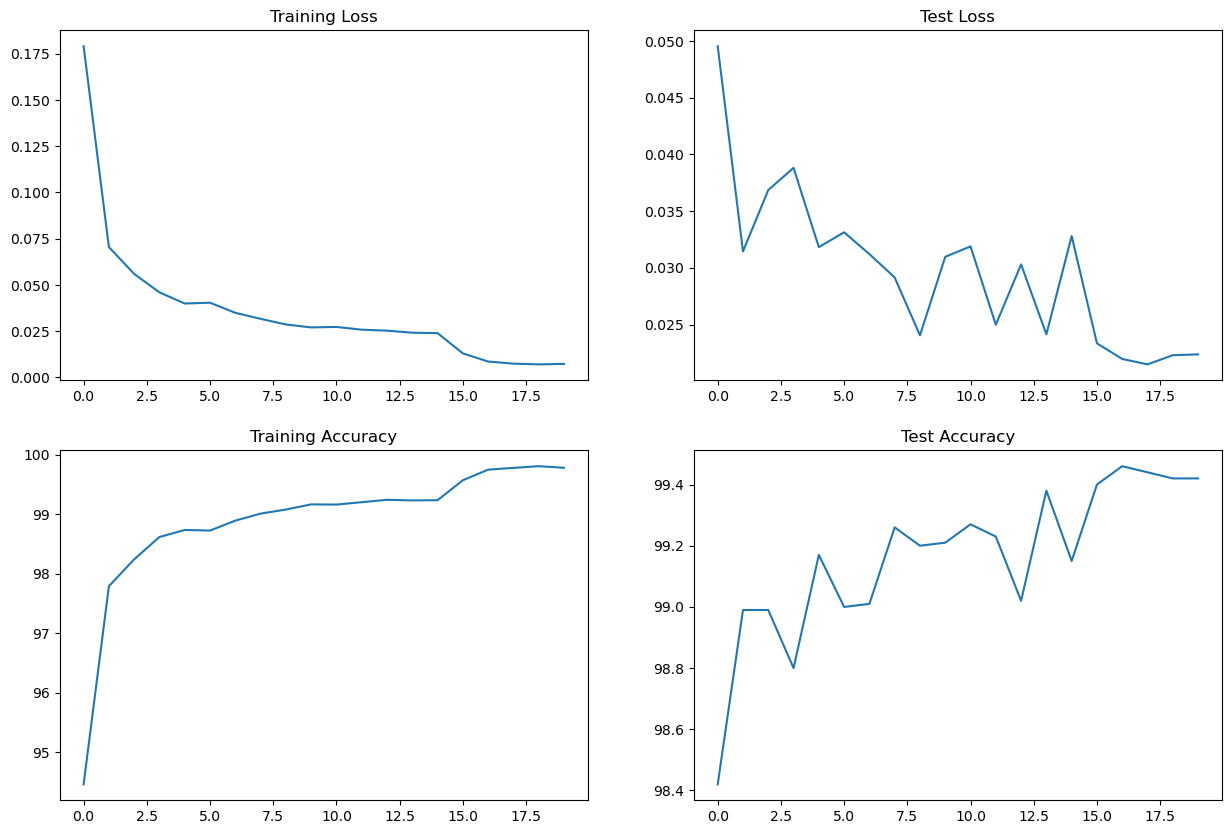

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")